### Using Text Classification to Detect Suicide Ideation 
**Goal:** The goal of this project is to identify more effective ways for detecting people who are at risk for suicide. We will be training several classification models (Naive Bayes, Logistic Regression, Decision Trees, SVC) to detect suicide ideation from social media posts and comparing their performances to identify the best model, which we will further scrutinize to identify the features (words) which most effectively enhance the accuracy of predicting whether a user is at risk for suicide.

**Data Problem:** The data task is to train and tune multiple binary text classification models that group social media posts into suicidal vs non-suicidal classes. 

**Expected Results:** The expected results of this project is a quality model with high accuracy that can be used to predict, from future/unseen posts, whether their writer is at risk for suicide. 

We will draw insights from this model by conducting a global analysis, using the ELI5 and LIME libraries identify the words/features used by the model for making accurate predictions. We will also be locally analyzing this model and evaluating its class prediction process for individual posts. Lastly, we will draw insights from our analyses and recommmend areas to research and courses to undertake for future work in detecting suicide ideation.  

**Data**

The data is sourced from Kaggle.


Link: https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch 
- The data are a collection of posts collected from the 'SuicideWatch' and 'teenagers' subreddits from the Reddit platform using PushshiftAPI. Posts were created between 16 December 2008 - 2 January 2021
- Social media posts collected from the 'SuicideWatch' subreddit are labelled 'suicide', while posts collected from 'teenagers' are labelled 'non-suicide'

#### Import and Setup

In [38]:
import nltk
import time
import eli5
import string
import warnings
import numpy as np
import pandas as pd 
import seaborn as sns 
import plotly.express as px
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

from nltk.corpus import stopwords 
from nltk.tokenize import TweetTokenizer
from nltk import word_tokenize, sent_tokenize 
from nltk.stem import PorterStemmer, WordNetLemmatizer 

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV 
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score,f1_score, classification_report

sns.set_style("whitegrid")
sns.set_palette("rocket")

warnings.simplefilter(action='ignore')

In [3]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /Users/lois/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/lois/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/lois/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

#### Data Overview 

- 232074 samples/rows 
- 3 columns: 
       1. Unnamed: 0: A unique ID for each row 
       2. text: Content of the social media post
       3. class: Whether the poster is suicidal or not; values: ['suicide', 'non-suicide']

In [4]:
suicide = pd.read_csv("/Users/Lois/Downloads/ML ipynb/Capstone/SuicideDetection.csv")

In [5]:
print(suicide.shape)
suicide.head()

(232074, 3)


,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [6]:
#using a random sample of 20,000 entries for model training
suicide = suicide.sample(20000, random_state = 42)

In [111]:
#sample suicidal post
print('Class:', suicide['class'].iloc[0])
suicide['text'].iloc[0]

Class: suicide


"I Don't know?7? Months self harm free and the urge just gets stronger and stronger every day. The past few days I've just been shit... \nMy family stresses me out especially my nephew (he's 12) My mum has full custody of him and he's told me to go kill myself numerous times.. I wish it was that easy.\nMy partners family stresses me out especially over the past few days. \nStress is my trigger \nI just want to scream and cry. \nI live near the woods so I could go out and scream till I can't possibly scream anymore but the cops will probably get called...\nMy OH knows about my depression but he doesn't really know how I'm feeling at the moment. He would want to come over and make sure I'm OK but he's fucking annoying. He annoys me all the time by doing small stupid things. \nI don't even know where I'm going with the post? \n\n"

In [112]:
#sample non-suicidal post
print('Class:', suicide['class'].iloc[1])
suicide['text'].iloc[1]

Class: non-suicide


'I HAVE TO START BECOMING RICH I HAVE TO START MY COMPANY SO WHEN I BECOME 16 I CAN AFFORD A BIG VAN AND GO ON TRIPS WITH MY FRIENDS BUT I HAVE NO TIME LEFT I HAVE TO START WORKING'

#### Exploratory Data Analysis

In [8]:
suicide.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 74414 to 89712
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  20000 non-null  int64 
 1   text        20000 non-null  object
 2   class       20000 non-null  object
dtypes: int64(1), object(2)
memory usage: 625.0+ KB


In [9]:
#no null values
suicide.isna().sum()

Unnamed: 0    0
text          0
class         0
dtype: int64

**Post Length** 

The length of the majority of posts are under 500 characters, with very few posts exceeding 2000 charaters.  

In [10]:
#summary statistics of post length
suicide['char_count'] = suicide.text.apply(len)
print('Mean character count:', suicide['char_count'].mean())
print('Min character count:', suicide['char_count'].min())
print('Max character count:', suicide['char_count'].max())

Mean character count: 680.14645
Min character count: 7
Max character count: 40106


(0.0, 10000.0)

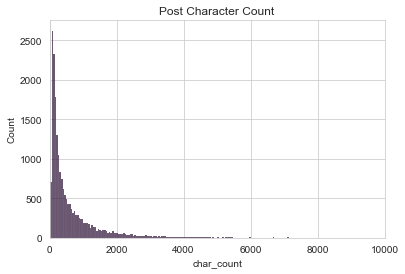

In [11]:
#character count visualization
fig, ax = plt.subplots()
sns.histplot(suicide['char_count'], ax = ax).set_title('Post Character Count')
ax.set_xlim(0, 10000)

**Data Distribution**

The data are balanced, with comparable counts of suicide and non-suicide posts. This makes accuracy score a suitable metric for evaluating models trained on this data. 

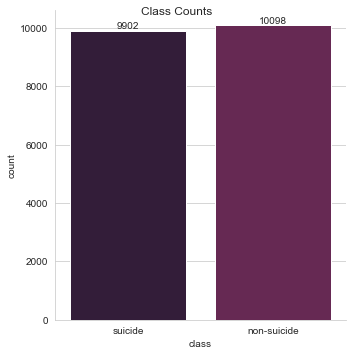

In [15]:
#checking class distribution 
#the data is balanced: Comparable counts of suicide vs non-suicide posts

fig = sns.catplot(x = 'class', kind = 'count', data = suicide)
fig.fig.suptitle("Class Counts")
for fig in fig.axes.flat:
    fig.bar_label(fig.containers[0])

#### Data Setup

In [7]:
#only keeping the text and class columns
suicide.drop("Unnamed: 0", axis = 1, inplace = True)

#renaming "class" column as "suicide"
suicide.rename({"class" : "suicide"}, axis = 1, inplace = True)

#numerically representing the contents of "suicide" column
suicide.replace({"suicide" : 1, "non-suicide" : 0}, inplace = True)
suicide.head()

,text,suicide
74414,I Don't know?7? Months self harm free and the ...,1
149516,I HAVE TO START BECOMING RICH I HAVE TO START ...,0
12484,"A poem (haiku) for u/Me-Game-Dev hi, hello hel...",0
14043,I've honestly got no idea what to do anymore.I...,1
30673,Do you ever just cry? Like you just think abou...,0


In [8]:
#train test split
X = suicide['text']
y = suicide['suicide']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [9]:
#sample unprocessed post
X_train.iloc[0]

'This world is sick.This world needs to be destroyed. We cause each other immense suffering and tears. We are miserable creatures that stab our parents in the hearts while casting our own children to hungry wolves. Things look like they are getting better through the illusions of technology, but we are really just sinking deeper into the filthy, wicked mires of our unclean souls.\n\nI\'m not what would be considered "suicidal", but I do give up on this life. It\'s not a surprise to me that suicide rates are increasing around the world. People are throwing away their humanity for the superficial pleasures provided to them by technology, and our economies are absolutely raping us for this perverted privilege. We are becoming less human; it causes me grief. I have no idea what we\'ve become, but it needs to be destroyed.\n\nSomebody, save us.'

#### Text Preprocessing

A function is written to tokenize posts, remove stop words, punctuation, and capitalization, and finally implement steming on the posts. 

In [10]:
#tokenization, stop word removal, punctuation removal, lower casing, and stemming
def preprocess_text(text):
    tokenizer = TweetTokenizer(preserve_case = False)
    swords = stopwords.words('english')
    punc = list(string.punctuation)
    stemmer = PorterStemmer()
    
    proprocessed_text = []
    for entry in text:
        tokens = tokenizer.tokenize(entry)
        proprocessed_text.append([stemmer.stem(word) for word in tokens if word not in swords and word not in punc])
    return proprocessed_text

In [11]:
#preprocessing
pX_train = preprocess_text(X_train)
X_train = [' '.join(x) for x in pX_train]

pX_test = preprocess_text(X_test)
X_test = [' '.join(x) for x in pX_test]

In [12]:
#sample preprocessed post
X_train[0]

"world sick.thi world need destroy caus immens suffer tear miser creatur stab parent heart cast children hungri wolv thing look like get better illus technolog realli sink deeper filthi wick mire unclean soul i'm would consid suicid give life surpris suicid rate increas around world peopl throw away human superfici pleasur provid technolog economi absolut rape us pervert privileg becom less human caus grief idea we'v becom need destroy somebodi save us"

#### Model Training

Holdout cross validation will be implemented: Models will be trained on the training set and validated with the test set.

RandomizedSearchCV evaluated models using accuracy score, and fine tuned each model's hyperparameters to maximize this metric.

Accuracy is suitable because we have a balanced dataset. Accuracy measures the proportion of correctly predicted observations out of total observations and is calculated as (True Positive count + True Negative count) / (Total count), or

$$
\frac{TP + TN}{TP + TN + FP + FN}
$$

**Naïve Bayes** 

A pipeline object is created to standardize the data using TF-IDF and instantiate a Naïve Bayes model. RandomizedSearchCV is used to find the optimal alpha value (options: [1, 0.1, 0.01, 0.001, 0]), which is 0.1.

In [13]:
#naive bayes model with tfidf vectorizer 
nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('bayes', MultinomialNB())
])

In [14]:
#nb params
nb_params = {'bayes__alpha' : [1, 0.1, 0.01, 0.001, 0]}

In [15]:
#grid search 
nb_grid = RandomizedSearchCV(estimator = nb,
                            param_distributions = nb_params)

start = time.time()
nb_grid.fit(X_train, y_train)
stop = time.time()

#stats
nb_time = stop - start
nb_params = nb_grid.best_params_
nb_acc = nb_grid.score(X_test, y_test)
nb_rec = recall_score(y_test, nb_grid.predict(X_test))
nb_f1 = f1_score(y_test, nb_grid.predict(X_test))

In [29]:
#best params
nb_params

{'bayes__alpha': 0.1}

**Logistic Regression**

A pipeline object is created to standardize the data using TF-IDF and instantiate a Logistic Regression model. RandomizedSearchCV is used to find (1) the optimal penlaty, with the options being ['l1', 'l2', 'none'] and (2) whether an intercept term should be included (options: [True, False]). The best model has l2 penalty and an intercept term.

In [16]:
#logreg + tfidf 
lgr = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lgr', LogisticRegression())
])

In [17]:
#lgr params
lgr_params = {'lgr__penalty' : ['l1', 'l2', 'none'],
             'lgr__fit_intercept' : [True, False]}

In [18]:
#gridsearch 
lgr_grid = RandomizedSearchCV(estimator = lgr,
                   param_distributions = lgr_params)


start = time.time()
lgr_grid.fit(X_train, y_train)
stop = time.time()

#stats
lgr_time = stop - start
lgr_params = lgr_grid.best_params_
lgr_acc = lgr_grid.score(X_test, y_test)
lgr_rec = recall_score(y_test, lgr_grid.predict(X_test))
lgr_f1 = f1_score(y_test, lgr_grid.predict(X_test))

In [30]:
#best params
lgr_params

{'lgr__penalty': 'l2', 'lgr__fit_intercept': True}

**Decision Tree**

A pipeline object is created to standardize the data using TF-IDF and instantiate a Decision Tree model. RandomizedSearchCV is used to find (1) the optimal tree criterion, with the options being ['gini', 'entropy'], (2) max depth (options: [None, 1, 2, 3, 4]), and (3) the minimum sample count required to split a node (options: [1, 2, 3, 4]). The best model has a minimum sample split of 3, no max depth, and uses the gini criterion. 

In [21]:
#decision tree + tfidf 
tree = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('tree', DecisionTreeClassifier())
])

In [22]:
#tree params
tree_params = {'tree__criterion' : ['gini', 'entropoy'],
              'tree__max_depth' : [None, 1, 2, 3, 4],
              'tree__min_samples_split' : [1, 2, 3, 4]}

In [23]:
#gridsearch
tree_grid = RandomizedSearchCV(estimator = tree,
                   param_distributions = tree_params)

start = time.time()
tree_grid.fit(X_train, y_train)
stop = time.time()

#stats
tree_time = stop - start
tree_params = tree_grid.best_params_
tree_acc = tree_grid.score(X_test, y_test)
tree_rec = recall_score(y_test, tree_grid.predict(X_test))
tree_f1 = f1_score(y_test, tree_grid.predict(X_test))

In [31]:
#best params
tree_params

{'tree__min_samples_split': 3,
 'tree__max_depth': None,
 'tree__criterion': 'gini'}

**SVC**

A pipeline object is created to standardize the data using TF-IDF and instantiate a Support Vector Classifier model using a linear kernel. RandomizedSearchCV is used to (1) The optimal C value (options: [0.1, 1, 10, 100, 1000]) and (2) Probability (options: [True, False]). The best model has a probability = True and a C value of 1. 

In [52]:
#svc + tfidf 
svc = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', SVC(kernel = 'linear'))
])

In [55]:
#params
svc_params = {'svc__C' : [0.1, 1, 10, 100, 1000],
             'svc__probability' : [True, False]}

In [56]:
#gridsearch
svc_grid = RandomizedSearchCV(estimator = svc,
                   param_distributions = svc_params)

start = time.time()
svc_grid.fit(X_train, y_train)
stop = time.time()

#stats
svc_time = stop - start
svc_params = svc_grid.best_params_
svc_acc = svc_grid.score(X_test, y_test)
svc_rec = recall_score(y_test, svc_grid.predict(X_test))
svc_f1 = f1_score(y_test, svc_grid.predict(X_test))

In [57]:
#best params
svc_params

{'svc__probability': True, 'svc__C': 1}

#### Model evaluation and summary of results 

Best accuracy: **SVC** with a score of 0.924

Best recall: **Naive Bayes** with a score of 0.955

Best f1: **SVC** with a score of 0.924

In [58]:
#build df 
results_df = pd.DataFrame({'model': ['Logistic Regression', 'Decision Tree', 'Naive Bayes', 'SVC'], 
              'speed' : [lgr_time, tree_time, nb_time, svc_time],
              'best_params': [lgr_params, tree_params, nb_params, svc_params],
              'accuracy': [lgr_acc, tree_acc, nb_acc, svc_acc],
              'recall' : [lgr_rec, tree_rec, nb_rec, svc_rec],
              'f1' : [lgr_f1, tree_f1, nb_f1, svc_acc]}).set_index('model')

In [59]:
results_df

,speed,best_params,accuracy,recall,f1
model,,,,,
Logistic Regression,26.134971,"{'lgr__penalty': 'l2', 'lgr__fit_intercept': T...",0.9174,0.898528,0.916210
Decision Tree,61.063204,"{'tree__min_samples_split': 3, 'tree__max_dept...",0.8222,0.814564,0.821593
Naive Bayes,16.348134,{'bayes__alpha': 0.1},0.8896,0.955432,0.896900
SVC,2338.963991,"{'svc__probability': True, 'svc__C': 1}",0.9244,0.915639,0.924400


##### Comparing confusion matrices to select the best model 
Confusion matrices indicate the counts of each error type a model made in the classification task. In these plots, 0 = not suicidal and 1 = suicidal.

FP = False Positive, FN = False Negative 
- The Logistic Regression model has nearly 2x as many FN as FP
- The Naive Bayes model has nearly 4x as many FP as FN
- The Decision Tree model has similar FP and FN counts with slightly more FN
- The SVC model has slightly more FN than FP 

In [60]:
#compile preds
log_preds = lgr_grid.predict(X_test)
nb_preds = nb_grid.predict(X_test)
tree_preds = tree_grid.predict(X_test)
svc_preds = svc_grid.predict(X_test)

Text(0.5, 1.0, 'Logistic Regression Confusion Matrix')

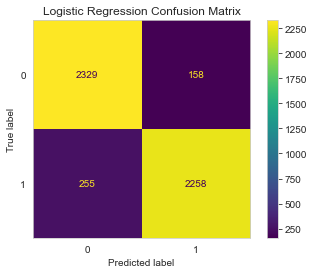

In [34]:
#logreg 
ConfusionMatrixDisplay(confusion_matrix(y_test, log_preds)).plot()
plt.grid(False)
plt.title("Logistic Regression Confusion Matrix")

Text(0.5, 1.0, 'Naive Bayes Confusion Matrix')

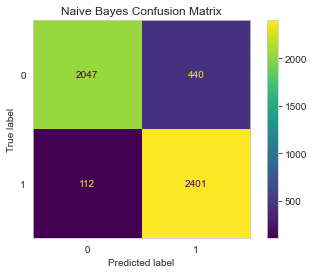

In [35]:
#naive bayes
ConfusionMatrixDisplay(confusion_matrix(y_test, nb_preds)).plot()
plt.grid(False)
plt.title("Naive Bayes Confusion Matrix")

Text(0.5, 1.0, 'Decision Tree Confusion Matrix')

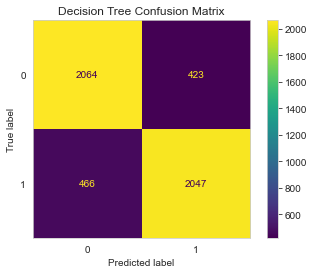

In [36]:
#decision tree
ConfusionMatrixDisplay(confusion_matrix(y_test, tree_preds)).plot()
plt.grid(False)
plt.title("Decision Tree Confusion Matrix")

Text(0.5, 1.0, 'SVC Confusion Matrix')

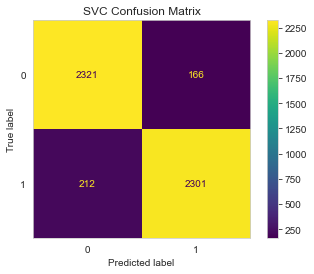

In [61]:
#svc
ConfusionMatrixDisplay(confusion_matrix(y_test, svc_preds)).plot()
plt.grid(False)
plt.title("SVC Confusion Matrix")

**Selecting the best model**

After taking into account the accuracy, f1, and recall scores and evaluating the confusion matrices, it would be logical to crown SVC as the best model. It has the highest accuracy and f1 score, and the second highest recall score. We will be further analyzing and interpreting this model in Part II, titled CapstoneEvaluation. 